# CIFAR10을 CNN으로 학습하기. 여러 학습 방법으로 비교

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

#learning rate decay
from torch.optim import lr_scheduler

batch_size=16
#learning_rate=0.002
learning_rate=0.01
num_epoch=60

## 1. CIFAR10 train, test dataset 가져오기

In [6]:
cifar_train=dset.CIFAR10("CIFAR10/",train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
cifar_test=dset.CIFAR10("CIFAR10/",train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

#(2) Data augmentation
#train할 때만 필요(많이 가지게끔..), test할때는 필요가 없다.
'''
cifar_train=dset.CIFAR10("CIFAR10/",train=True, transform=
                        transforms.Compose([transforms.Scale(36),transforms.CenterCrop(32),
                        transforms.RandomHorizontalFlip(),transforms.Lambda(lambda x: x.rotate(90)),
                        transforms.ToTensor()]))
'''
#(4) Data Normalization
'''
cifar_train=dset.CIFAR10("CIFAR10/",train=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),
                        ])
                         ,target_transform=None,download=False)
cifar_test=dset.CIFAR10("CIFAR10/",train=False,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            #train이랑 같은 값 넣어야함
                            transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),
                        ])
                         ,target_transform=None,download=False)
'''
'''
#(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
cifar_train=dset.CIFAR10("CIFAR10/",train=True,
                        transform=transforms.Compose([
                        transforms.RandomCrop(34, padding=4),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
                        ])
                         ,target_transform=None,download=True)

cifar_test=dset.CIFAR10("CIFAR10/",train=False,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            #train이랑 같은 값 넣어야함
                            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
                        ])
                         ,target_transform=None,download=True)
                         '''

Files already downloaded and verified
Files already downloaded and verified


'\n#(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)\ncifar_train=dset.CIFAR10("CIFAR10/",train=True,\n                        transform=transforms.Compose([\n                        transforms.RandomCrop(34, padding=4),\n                        transforms.RandomHorizontalFlip(),\n                        transforms.ToTensor(),\n                        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),\n                        ])\n                         ,target_transform=None,download=True)\n\ncifar_test=dset.CIFAR10("CIFAR10/",train=False,\n                        transform=transforms.Compose([\n                            transforms.ToTensor(),\n                            #train\xec\x9d\xb4\xeb\x9e\x91 \xea\xb0\x99\xec\x9d\x80 \xea\xb0\x92 \xeb\x84\xa3\xec\x96\xb4\xec\x95\xbc\xed\x95\xa8\n                            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),\n                        ])\n                         ,ta

## 2. 대략적인 데이터 형태

('cifar_train \xea\xb8\xb8\xec\x9d\xb4:', 50000)
('cifar_test \xea\xb8\xb8\xec\x9d\xb4:', 10000)
('image data \xed\x98\x95\xed\x83\x9c: ', torch.Size([3, 32, 32]))
('label: ', 8)


<function matplotlib.pyplot.show>

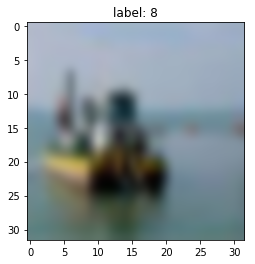

In [7]:
print ("cifar_train 길이:",len(cifar_train))
print ("cifar_test 길이:",len(cifar_test))

#데이터 하나 형태
image, label=cifar_train.__getitem__(193) #1번째 데이터
print ("image data 형태: ",image.size())
print ("label: ",label)

#그리기
img=image.numpy() #image 타입을 numpy로 변환(3, 32, 32)

#(3,32,32)->(32,32,3)
r,g,b=img[0,:,:],img[1,:,:],img[2,:,:]

#img=img.reshape(img.shape[1],img.shape[2],img.shape[0])
img2=np.zeros((img.shape[1],img.shape[2],img.shape[0]))
img2[:,:,0],img2[:,:,1],img2[:,:,2]=r,g,b

plt.title("label: %d" %label)
plt.imshow(img2,interpolation='bicubic')
plt.show

## 실험 시작

In [8]:
def ComputeAccr(dloader, imodel):
    correct=0
    total=0
    
    for j, [imgs,labels] in enumerate(dloader): #batch_size 만큼
        img=Variable(imgs,volatile=True).cuda() #x
        #label=Variable(labels) #y
        label=Variable(labels).cuda()
        #.cuda(): GPU에 로드되기 위함, 만약 CPU로 설정되어 있다면 에러남
        
        output=imodel.forward(img)#forward prop.
        _, output_index=torch.max(output,1)
        
        total+=label.size(0)
        correct+=(output_index==label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))

In [9]:
def ComputeAccr2(dloader, imodel):
    correct=0
    total=0
    
    for j, [imgs,labels] in enumerate(dloader): #batch_size 만큼
        img=Variable(imgs,volatile=True).cuda() #x
        #label=Variable(labels) #y
        label=Variable(labels) .cuda()
        #.cuda(): GPU에 로드되기 위함, 만약 CPU로 설정되어 있다면 에러남
        
        output=imodel.forward(img)#forward prop.
        _, output_index=torch.max(output,1)
        
        total+=label.size(0)
        correct+=(output_index==label).sum().float()
    return format(100*correct/total)

In [10]:
# ==3.데이터 로드함수
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:],batch_size=batch_size,shuffle=True,num_workers=2,drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)

# ==4.모델 선언
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(3,16,3,padding=1),
            nn.ELU(),
            #nn.FeatureAlphaDropout(0.4),
            nn.Dropout2d(0.4), #(1)drop out -->0.2: 몇퍼센트의 확률로 끌 것인가?(설정 안하면 0.5가됨)
            #nn.BatchNorm2d(16), #(5) Batch normalization
            nn.Conv2d(16,32,3,padding=1),
            nn.ELU(),
            #nn.FeatureAlphaDropout(0.4),
            nn.Dropout2d(0.4), #(1)drop out
            #nn.BatchNorm2d(32), #(5) Batch normalization
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1),
            nn.ELU(),
            #nn.FeatureAlphaDropout(0.4),
            nn.Dropout2d(0.4), #(1)drop out
            #nn.BatchNorm2d(64), #(5) Batch normalization
            nn.MaxPool2d(2,2)
        )
        self.fc_layer=nn.Sequential(
            
            nn.Linear(64*8*8,100),
            nn.ELU(),
            #nn.functional.alpha_dropout(0.4),
            #nn.FeatureAlphaDropout(0.4),
            nn.Dropout2d(0.4), #(1)drop out
            #nn.BatchNorm1d(100), #(5) Batch normalization, 얘만 fully connected 다음이라 1d임
            nn.Linear(100,10)
            
        )
    
        #(3)weight initialization
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                init.kaiming_normal(m.weight.data)##RELU일 때
                m.bias.data.fill_(0)

            if isinstance(m,nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
     
    
    def forward(self,x):
        out=self.layer(x)
        out=out.view(batch_size,-1)
        out=self.fc_layer(out)
        
        return out
model=CNN().cuda()

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:43: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:47: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [ ]:
# ==5. loss, optimizer
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)#,momentum=0.9)
#optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate ,momentum=0.9, nesterov=True)
#optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=0.0001) #(6)Adam optimizer
scheduler=lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.2) #(7)learning rate decay


# ==6. 학습
accr_test=[]
accr_train=[]
error_train=[]
error_test=[]
epoch=[]

model.train()
for i in range(num_epoch):
    print("===try:",i)
    for j,[image,label] in enumerate(train_loader):

        x=Variable(image).cuda()
        y_=Variable(label).cuda()
        
        optimizer.zero_grad()
        output=model.forward(x)
        loss=loss_func(output,y_)
        loss.backward()
        optimizer.step()

        if j%1000==0:
            print(j,loss)

    model.eval()
    accr_train.append(float(ComputeAccr2(train_loader,model)))
    error_train.append(100-float(ComputeAccr2(train_loader,model)))
    accr_test.append(float(ComputeAccr2(test_loader,model)))
    error_test.append(100-float(ComputeAccr2(test_loader,model)))
    model.train()
    epoch.append(i)
    # model.eval()
    # accr.append(ComputeAccr2(test_loader,model))
    # epoch.append(i)
    # model.train()

model.eval()


('===try:', 0)
(0, tensor(4.4160, device='cuda:0', grad_fn=<NllLossBackward>))
(1000, tensor(1.8377, device='cuda:0', grad_fn=<NllLossBackward>))
(2000, tensor(2.0059, device='cuda:0', grad_fn=<NllLossBackward>))
(3000, tensor(1.3520, device='cuda:0', grad_fn=<NllLossBackward>))


/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


('===try:', 1)
(0, tensor(1.5936, device='cuda:0', grad_fn=<NllLossBackward>))
(1000, tensor(1.5144, device='cuda:0', grad_fn=<NllLossBackward>))
(2000, tensor(1.7583, device='cuda:0', grad_fn=<NllLossBackward>))
(3000, tensor(1.7319, device='cuda:0', grad_fn=<NllLossBackward>))
('===try:', 2)
(0, tensor(1.9863, device='cuda:0', grad_fn=<NllLossBackward>))
(1000, tensor(1.4779, device='cuda:0', grad_fn=<NllLossBackward>))
(2000, tensor(1.0205, device='cuda:0', grad_fn=<NllLossBackward>))
(3000, tensor(1.5277, device='cuda:0', grad_fn=<NllLossBackward>))
('===try:', 3)
(0, tensor(1.4857, device='cuda:0', grad_fn=<NllLossBackward>))
(1000, tensor(1.5029, device='cuda:0', grad_fn=<NllLossBackward>))
(2000, tensor(1.3949, device='cuda:0', grad_fn=<NllLossBackward>))
(3000, tensor(1.4325, device='cuda:0', grad_fn=<NllLossBackward>))
('===try:', 4)
(0, tensor(1.8072, device='cuda:0', grad_fn=<NllLossBackward>))
(1000, tensor(0.9181, device='cuda:0', grad_fn=<NllLossBackward>))
(2000, tensor(

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 73.91999816894531


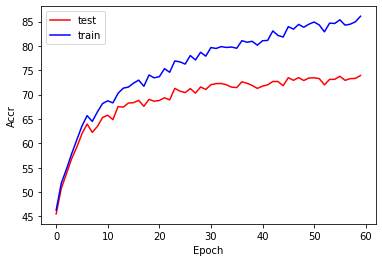

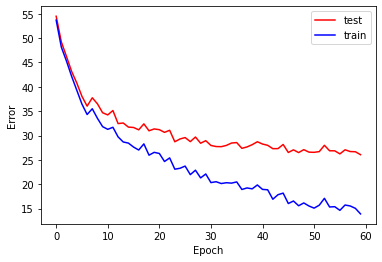

In [136]:
#epoch 60, 최선의결과랑 같음
ComputeAccr(test_loader,model)
plt.plot(epoch,accr_test,'r-')
plt.plot(epoch,accr_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.legend(['test','train'])
plt.show()

plt.plot(epoch,error_test,'r-')
plt.plot(epoch,error_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(['test','train'])
plt.show()

In [138]:
netname = './my_model.pkl'
torch.save(model, netname, )

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


##21. 결국은 가장 좋았던 결과로

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 69.54000091552734


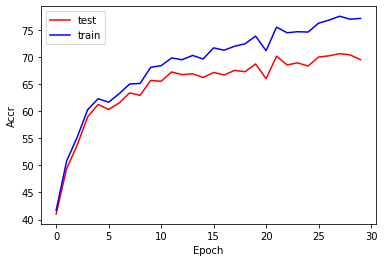

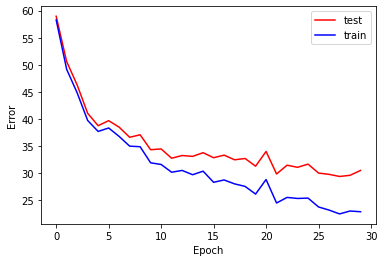

In [129]:
#epoch 30, 최선의결과랑 같음
ComputeAccr(test_loader,model)
plt.plot(epoch,accr_test,'r-')
plt.plot(epoch,accr_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.legend(['test','train'])
plt.show()

plt.plot(epoch,error_test,'r-')
plt.plot(epoch,error_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(['test','train'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 62.96073913574219


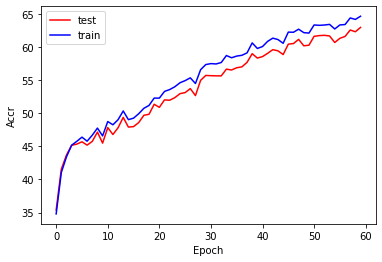

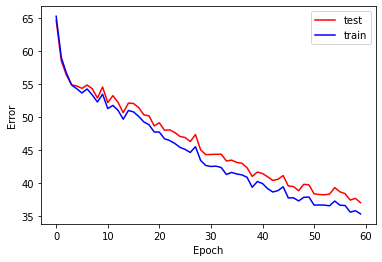

In [121]:
#0.625, 0.4, batch 128
ComputeAccr(test_loader,model)
plt.plot(epoch,accr_test,'r-')
plt.plot(epoch,accr_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.legend(['test','train'])
plt.show()

plt.plot(epoch,error_test,'r-')
plt.plot(epoch,error_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(['test','train'])
plt.show()

##20. train data의 정확도와 test data의 정확도 비교
실험 순서는 **아래부터임**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 49.18870162963867


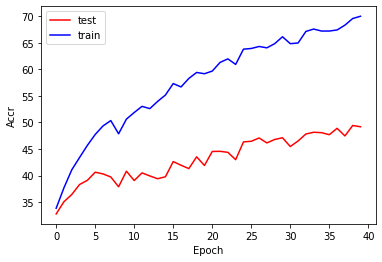

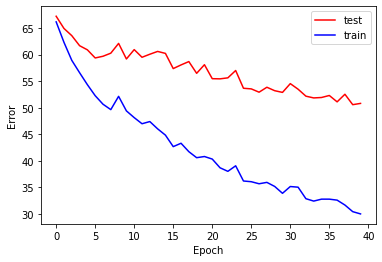

In [81]:
#selu ,알파드롭아웃 0.4resize+0.001, batch, 16,adam, data nomalization 논문수치, batch size 128,epoch 40, learning rate 지우고 adam weight 추가
ComputeAccr(test_loader,model)
plt.plot(epoch,accr_test,'r-')
plt.plot(epoch,accr_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.legend(['test','train'])
plt.show()

plt.plot(epoch,error_test,'r-')
plt.plot(epoch,error_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(['test','train'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 66.64663696289062


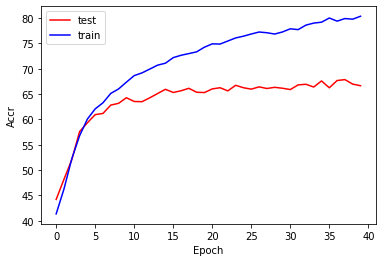

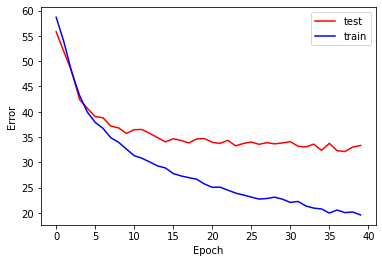

In [69]:
#selu ,드롭아웃 막 넣어봄 0.4resize+0.001, batch, 16,adam, data nomalization 논문수치, batch size 128,epoch 40, learning rate 지우고 adam weight 추가
ComputeAccr(test_loader,model)
plt.plot(epoch,accr_test,'r-')
plt.plot(epoch,accr_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.legend(['test','train'])
plt.show()

plt.plot(epoch,error_test,'r-')
plt.plot(epoch,error_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(['test','train'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 64.31290435791016


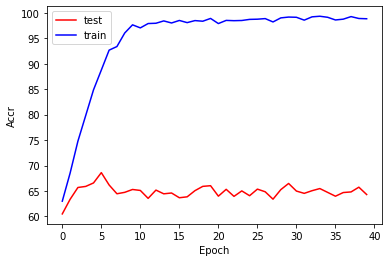

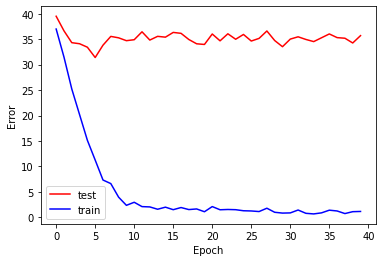

In [62]:
#selu resize+0.001, batch, 16,adam, data nomalization 논문수치, batch size 128,epoch 40, learning rate 지우고 adam weight 추가
ComputeAccr(test_loader,model)
plt.plot(epoch,accr_test,'r-')
plt.plot(epoch,accr_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.legend(['test','train'])
plt.show()

plt.plot(epoch,error_test,'r-')
plt.plot(epoch,error_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(['test','train'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 63.902244567871094


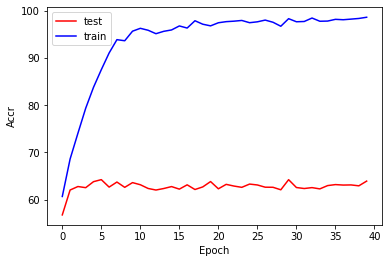

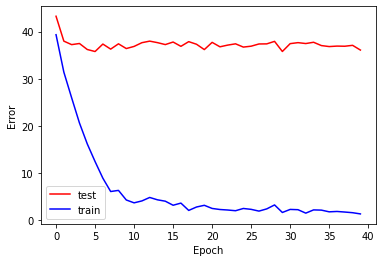

In [54]:
#selu resize+0.001, 16,adam, data nomalization 논문수치, batch size 128,epoch 40, learning rate 지우고 adam weight 추가
ComputeAccr(test_loader,model)
plt.plot(epoch,accr_test,'r-')
plt.plot(epoch,accr_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.legend(['test','train'])
plt.show()

plt.plot(epoch,error_test,'r-')
plt.plot(epoch,error_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(['test','train'])
plt.show()

In [0]:
netname = './nets/my_model.pkl'
torch.save(model, netname, )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 66.41626739501953


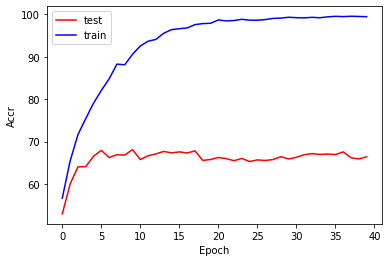

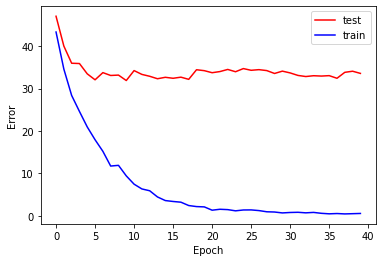

In [45]:
#dropout 0.1, resize+0.001, 16,adam, data nomalization 논문수치, batch size 128,epoch 40, learning rate 지우고 adam weight 추가
ComputeAccr(test_loader,model)
plt.plot(epoch,accr_test,'r-')
plt.plot(epoch,accr_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.legend(['test','train'])
plt.show()

plt.plot(epoch,error_test,'r-')
plt.plot(epoch,error_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(['test','train'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 61.137821197509766


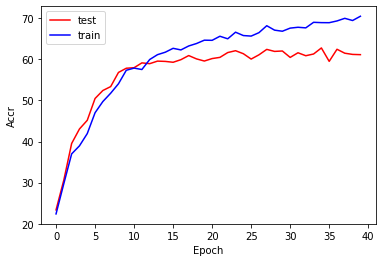

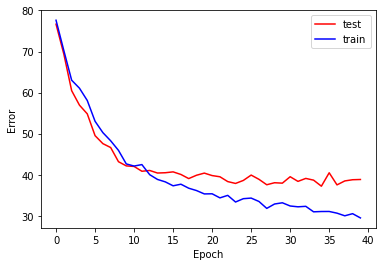

In [38]:
#resize+0.001, 16,adam, data nomalization 논문수치, batch size 128,epoch 40, learning rate 지우고 adam weight 추가
ComputeAccr(test_loader,model)
plt.plot(epoch,accr_test,'r-')
plt.plot(epoch,accr_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.legend(['test','train'])
plt.show()

plt.plot(epoch,error_test,'r-')
plt.plot(epoch,error_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(['test','train'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 61.09000015258789


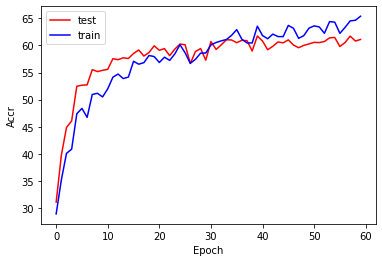

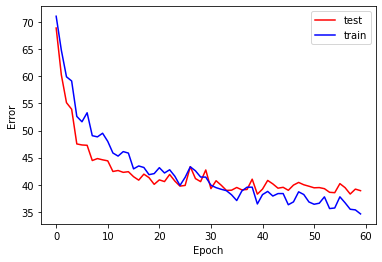

In [12]:
#resize+0.001, 16,adam, data nomalization 0.5
ComputeAccr(test_loader,model)
plt.plot(epoch,accr_test,'r-')
plt.plot(epoch,accr_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.legend(['test','train'])
plt.show()

plt.plot(epoch,error_test,'r-')
plt.plot(epoch,error_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(['test','train'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 66.04000091552734


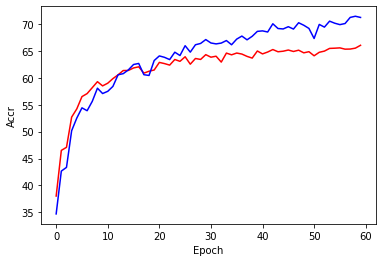

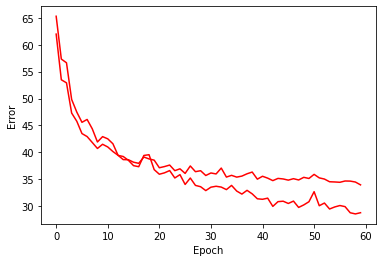

In [183]:
#resize+0.0005, 16,adam+0.5
plt.plot(epoch,accr_test,'r-')
plt.plot(epoch,accr_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.legend(['test','train'])
plt.show()

plt.plot(epoch,error_test,'r-')
plt.plot(epoch,error_train,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(['test','train'])
plt.show()

## 19. resize

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 66.02999877929688


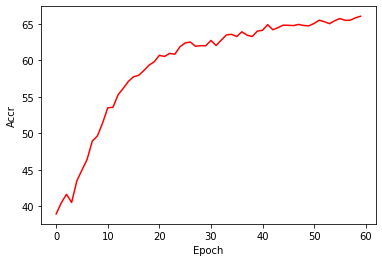

<function matplotlib.pyplot.show>

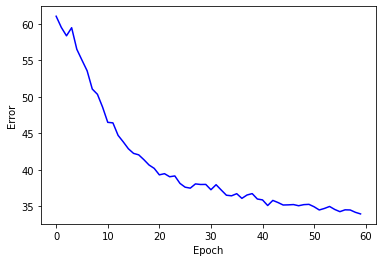

In [150]:
#resize+0.0001, 16,adam
ComputeAccr(test_loader,model)
plt.plot(epoch,accr,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.show()

plt.plot(epoch,error,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 65.4000015258789


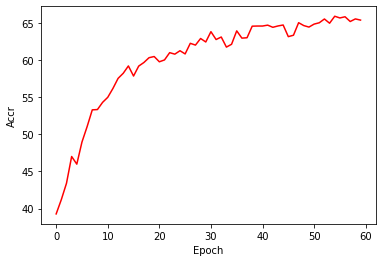

<function matplotlib.pyplot.show>

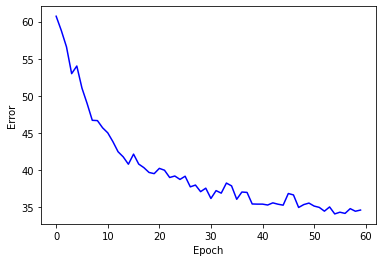

In [127]:
#resize, 8, 0.0625
ComputeAccr(test_loader,model)
plt.plot(epoch,accr,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.show()

plt.plot(epoch,error,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show

##18. nomalization

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 68.69999694824219


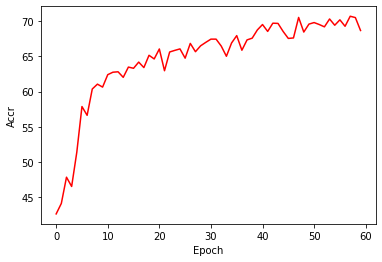

<function matplotlib.pyplot.show>

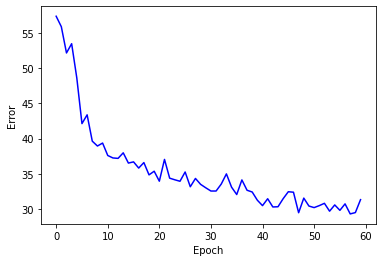

In [119]:
#18-epoch60-ELU-weight initialization--드롭아웃0.5-scheduler:optimizer,step_size=20,gamma=0.2-learningrate=0.00625-batch8
#batchx
ComputeAccr(test_loader,model)
plt.plot(epoch,accr,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.show()

plt.plot(epoch,error,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 56.73999786376953


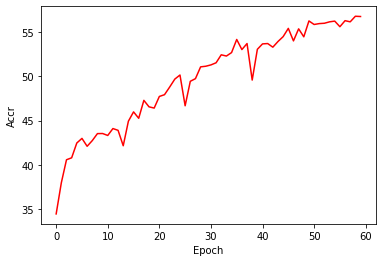

<function matplotlib.pyplot.show>

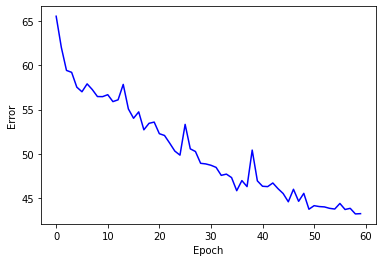

In [109]:
#18-epoch60-ELU-weight initialization--드롭아웃0.5-scheduler:optimizer,step_size=20,gamma=0.2-learningrate=0.0625-batch8
#batch
ComputeAccr(test_loader,model)
plt.plot(epoch,accr,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.show()

plt.plot(epoch,error,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 66.90705108642578


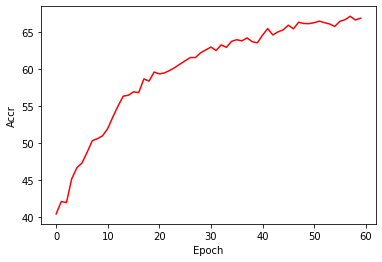

<function matplotlib.pyplot.show>

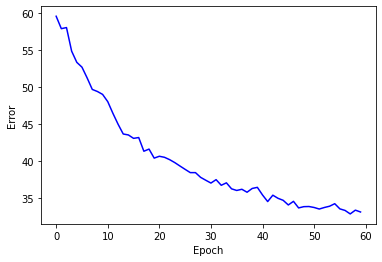

In [88]:
#18-epoch60-ELU-weight initialization--드롭아웃0.5-scheduler:optimizer,step_size=20,gamma=0.2-learningrate=0.01-batch32
#Batch normalization
ComputeAccr(test_loader,model)
plt.plot(epoch,accr,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.show()

plt.plot(epoch,error,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 67.9988021850586


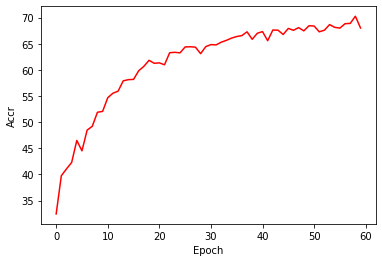

<function matplotlib.pyplot.show>

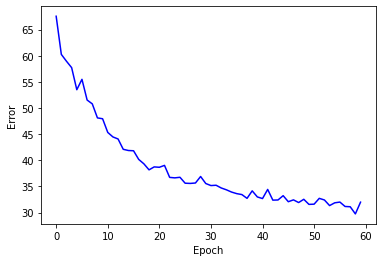

In [74]:
#18-epoch60-ELU-weight initialization--드롭아웃0.5-scheduler:optimizer,step_size=20,gamma=0.2-learningrate=0.01-batch32
#Data Normalization 값 변경
ComputeAccr(test_loader,model)
plt.plot(epoch,accr,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.show()

plt.plot(epoch,error,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 68.04888153076172


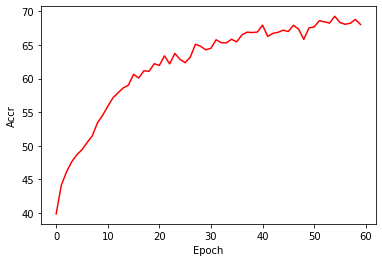

<function matplotlib.pyplot.show>

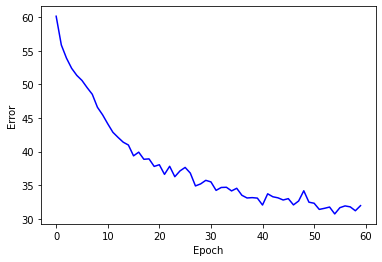

In [69]:
#18-epoch60-ELU-weight initialization--드롭아웃0.5-scheduler:optimizer,step_size=5,gamma=0.2-learningrate=0.01-batch32
#Data Normalization
ComputeAccr(test_loader,model)
plt.plot(epoch,accr,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.show()

plt.plot(epoch,error,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show

## 17. adam

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 52.63999938964844


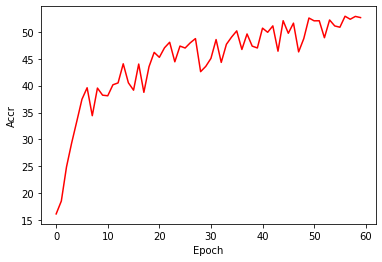

<function matplotlib.pyplot.show>

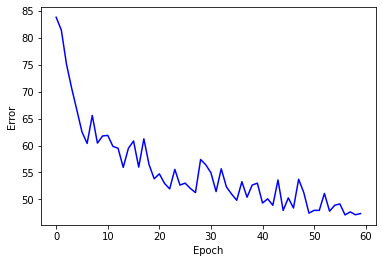

In [19]:
#17-2-epoch60-ELU-weight initialization-adam-드롭아웃0.5-scheduler:optimizer,step_size=5,gamma=0.2-learningrate=0.005-batch16
#Data Normalization, augmentation,batchnorm
ComputeAccr(test_loader,model)

plt.plot(epoch,accr,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.show()

plt.plot(epoch,error,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 10.0


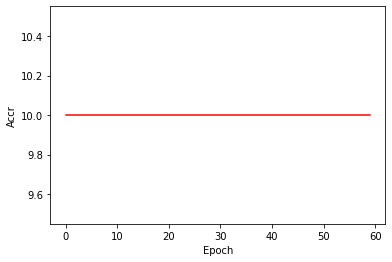

<function matplotlib.pyplot.show>

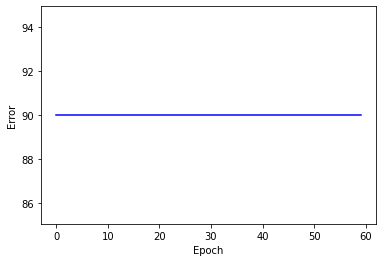

In [46]:
#17-epoch60-ELU-weight initialization-adam-드롭아웃0.5-scheduler:optimizer,step_size=5,gamma=0.2-learningrate=0.01-batch16
ComputeAccr(test_loader,model)

plt.plot(epoch,accr,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.show()

plt.plot(epoch,error,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 70.08999633789062


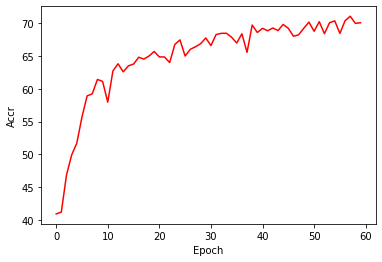

<function matplotlib.pyplot.show>

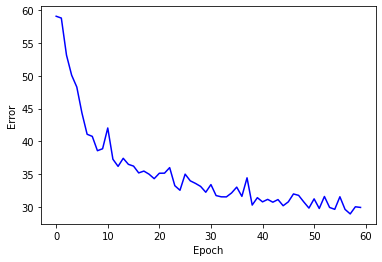

In [38]:
#16-5-epoch60-ELU-weight initialization-데이터정규화-드롭아웃0.5-scheduler:optimizer,step_size=5,gamma=0.2-learningrate=0.01-batch16
ComputeAccr(test_loader,model)

plt.plot(epoch,accr,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.show()

plt.plot(epoch,error,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 69.66999816894531


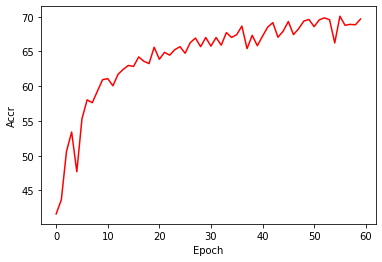

<function matplotlib.pyplot.show>

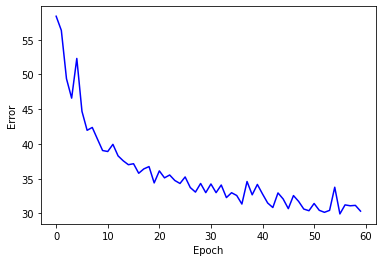

In [21]:
#16-4-epoch60-ELU-weight initialization-드롭아웃0.5-scheduler:optimizer,step_size=5,gamma=0.2-learningrate=0.01-batch16
ComputeAccr(test_loader,model)

plt.plot(epoch,accr,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.show()

plt.plot(epoch,error,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 65.87999725341797


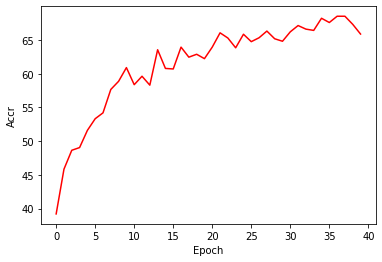

<function matplotlib.pyplot.show>

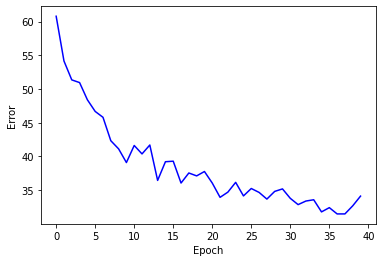

In [14]:
#16-3-epoch40-ELU-weight initialization-드롭아웃0.5-scheduler:optimizer,step_size=5,gamma=0.2-learningrate=0.01-batch16
ComputeAccr(test_loader,model)

plt.plot(epoch,accr,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.show()

plt.plot(epoch,error,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 72.45999908447266


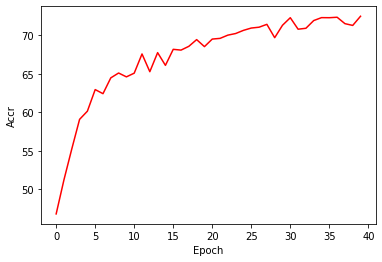

<function matplotlib.pyplot.show>

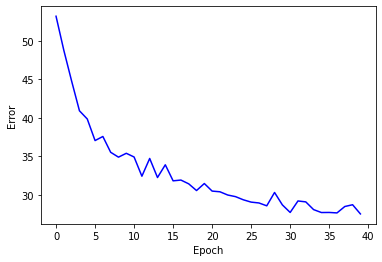

In [7]:
#16-2-epoch40-ELU-weight initialization-드롭아웃0.4-scheduler:optimizer,step_size=5,gamma=0.2-learningrate=0.01-batch16
ComputeAccr(test_loader,model)

plt.plot(epoch,accr,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.show()

plt.plot(epoch,error,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show

##16. dropout

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 71.30999755859375


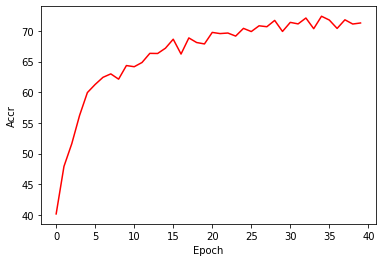

<function matplotlib.pyplot.show>

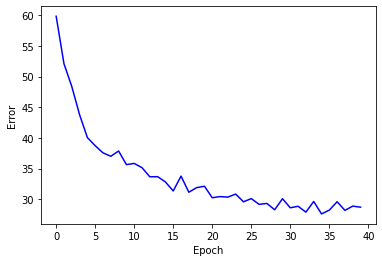

In [0]:
#16-2-epoch40-ELU-weight initialization-드롭아웃0.4-scheduler:optimizer,step_size=5,gamma=0.2-learningrate=0.01-batch16
ComputeAccr(test_loader,model)

plt.plot(epoch,accr,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.show()

plt.plot(epoch,error,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 74.55999755859375


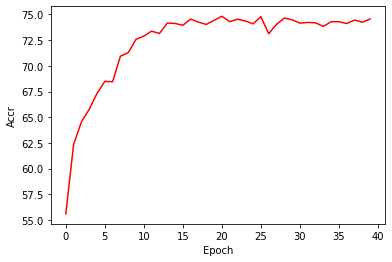

<function matplotlib.pyplot.show>

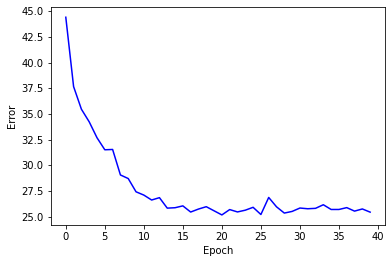

In [0]:
#16-1-epoch40-ELU-weight initialization-드롭아웃0.2-scheduler:optimizer,step_size=5,gamma=0.2-learningrate=0.01-batch16
ComputeAccr(test_loader,model)

plt.plot(epoch,accr,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.show()

plt.plot(epoch,error,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show

## 15.learning rate decay

In [0]:
#15-1-epoch20-ELU-weight initialization-scheduler:optimizer,step_size=5,gamma=0.2-learningrate=0.002-batch16
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 70.50999450683594


In [0]:
#15-2-epoch20-ELU-weight initialization-scheduler:optimizer,step_size=5,gamma=0.2-learningrate=0.01-batch16
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 71.5999984741211


In [0]:
#15-3-epoch30-ELU-weight initialization-scheduler:optimizer,step_size=7,gamma=0.2-learningrate=0.01-batch16
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 71.65999603271484


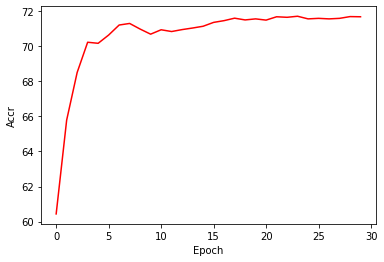

<function matplotlib.pyplot.show>

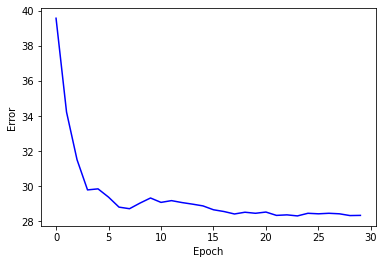

In [0]:
plt.plot(epoch,accr,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.show()

plt.plot(epoch,error,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 71.66999816894531


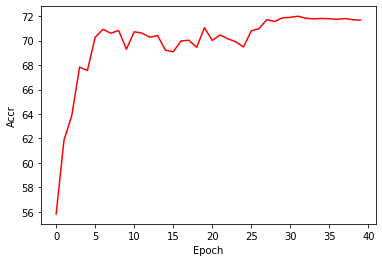

<function matplotlib.pyplot.show>

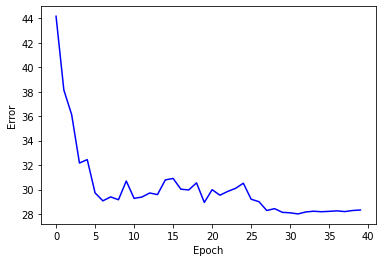

In [0]:
#15-4-epoch40-ReLU-weight initialization-scheduler:optimizer,step_size=5,gamma=0.2-learningrate=0.008-batch16
ComputeAccr(test_loader,model)

plt.plot(epoch,accr,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.show()

plt.plot(epoch,error,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 71.91999816894531


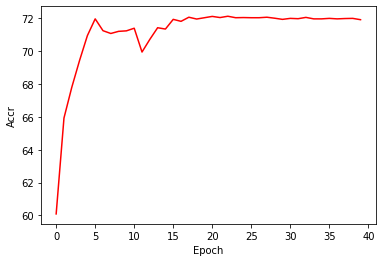

<function matplotlib.pyplot.show>

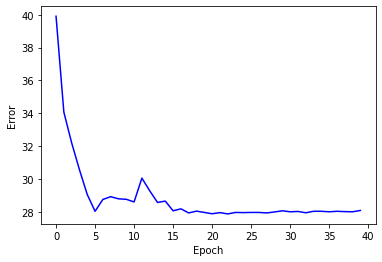

In [0]:
#15-5-epoch40-ELU-weight initialization-scheduler:optimizer,step_size=5,gamma=0.2-learningrate=0.01-batch16
ComputeAccr(test_loader,model)

plt.plot(epoch,accr,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.show()

plt.plot(epoch,error,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 71.16999816894531


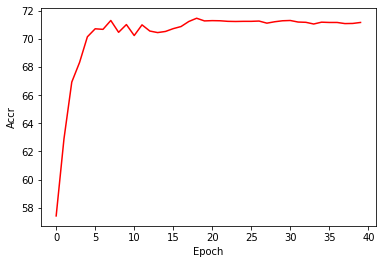

<function matplotlib.pyplot.show>

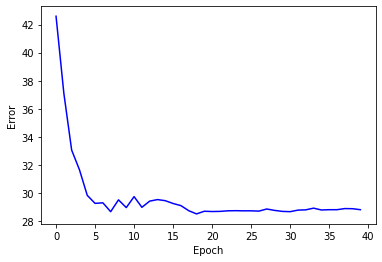

In [0]:
#15-6-epoch40-ELU-weight initialization-scheduler:optimizer,step_size=5,gamma=0.2-learningrate=0.0075-batch16
ComputeAccr(test_loader,model)

plt.plot(epoch,accr,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accr")
plt.show()

plt.plot(epoch,error,'b-')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show

## 14. Adam Optimizer

In [0]:
#14-epoch20-ELU-weight initialization-Adam Optimizer
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 65.8499984741211


In [0]:
#weight initialization없애고 adam
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 67.62999725341797


## 12, 13 normalization 

In [0]:
#12-epoch20-ELU-weight initialization-batch normalization
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 68.19999694824219


In [0]:
#13-epoch20-ELU-weight initialization-data normalization
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 68.8699951171875


## 11. weight initialization

In [0]:
#11-epoch20-ELU-weight initialization
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 69.50999450683594


##10. Dropout

In [0]:
#10-1-epoch20-ELU-Dropout-0.2
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 58.38999938964844


In [0]:
#10-2-epoch20-ELU-Dropout-0.4
ComputeAccr(test_loader,model)
#50.61000061035156

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 32.439998626708984


In [0]:
#10-3-epoch20-ELU-Dropout-0.5
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 50.279998779296875


In [0]:
#10-4-epoch20-ELU-Dropout-0.6
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 42.79999923706055


##9. Data augmentation

In [0]:
#9-epoch20-ELU-Data augmentation-center32
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 26.399999618530273


In [0]:
#9-2-epoch20-ELU-Data augmentation-center34
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 23.829999923706055


##5~8 활성화함수 선택하기

In [0]:
#5-epoch20-ELU
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 67.31999969482422


In [0]:
#6-epoch20-LeakyReLU
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 65.18000030517578


In [0]:
#7-epoch20-RReLU
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 65.11000061035156


In [0]:
#8-epoch20-PReLU
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 64.83999633789062


In [0]:
#5-2-epoch20-SELU
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 70.72000122070312


## 1~4 naive-epoch

In [0]:
#1-naive-epoch10
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 65.18999481201172


In [0]:
#2-naive-epoch20
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 65.18999481201172


In [0]:
#3-naive-epoch30
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 66.5199966430664


In [0]:
#4-naive-epoch50
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 64.2699966430664


# Try in 강의자료

## (0)Naive Test

In [0]:
ComputeAccr(test_loader,model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 15.2600002289


## (1)Drop out

In [0]:
ComputeAccr(test_loader,model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 15.9899997711


## (2) Data augmentation

In [0]:
ComputeAccr(test_loader,model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 25.9300003052


## (3) Weight initialization

In [0]:
ComputeAccr(test_loader,model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 43.5499992371


## (4)Data Normalization

In [0]:
ComputeAccr(test_loader,model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 30.9200000763


## (5) Batch normalization

In [0]:
ComputeAccr(test_loader,model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 59.5400009155


## (6) Adam optimizer

In [0]:
ComputeAccr(test_loader,model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 55.2200012207


## (7)learning rate decay

In [0]:
ComputeAccr(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 67.77999877929688


In [0]:
#